In [64]:
# ========================== KÜTÜPHANELER ==========================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.metrics import f1_score, jaccard_score # IoU için jaccard_score kullanılır

# ========================== GOOGLE DRIVE BAĞLANTISI ==========================
drive.mount('/content/drive')
DATASET_PATH = "/content/drive/MyDrive/wood_dataset/wood"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılacak cihaz: {device}")

# Görüntü boyutu
IMG_SIZE = (256, 256)

# Eğitim parametreleri
BATCH_SIZE = 16 # Bellek durumuna göre ayarlanabilir
EPOCHS = 50 # Örnek bir değer, model ve veri setine göre ayarlanabilir
LEARNING_RATE = 1e-4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kullanılacak cihaz: cpu


In [65]:
class WoodDataset(Dataset):
    def __init__(self, image_paths, transform=None, is_test_defect=False, ground_truth_dir=None):
        """
        Args:
            image_paths (list): Görüntü dosyalarının yollarını içeren liste.
            transform (callable, optional): Görüntülere uygulanacak dönüşümler.
            is_test_defect (bool): Bu veri setinin kusurlu test görüntülerini içerip içermediği.
            ground_truth_dir (str, optional): Kusurlu test görüntüleri için maske dosyalarının bulunduğu dizin.
        """
        self.image_paths = image_paths
        self.transform = transform
        self.is_test_defect = is_test_defect
        self.ground_truth_dir = ground_truth_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Görüntüyü PIL Image olarak aç ve RGB'ye dönüştür (eğer değilse)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image_tensor = self.transform(image)
        else:
            # Varsayılan dönüşümler (eğer transform sağlanmazsa)
            preprocess = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.ToTensor(), # Otomatik olarak [0,1] aralığına normalize eder ve (C, H, W) formatına getirir
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # İsteğe bağlı: [-1, 1] aralığına normalizasyon
            ])
            image_tensor = preprocess(image)

        if self.is_test_defect and self.ground_truth_dir:
            base_filename = os.path.basename(img_path)
            mask_filename_png = os.path.splitext(base_filename)[0] + ".png"
            mask_path_png = os.path.join(self.ground_truth_dir, mask_filename_png)

            mask_filename_jpg = os.path.splitext(base_filename)[0] + ".jpg"
            mask_path_jpg = os.path.join(self.ground_truth_dir, mask_filename_jpg)

            mask_path = None
            if os.path.exists(mask_path_png):
                mask_path = mask_path_png
            elif os.path.exists(mask_path_jpg):
                mask_path = mask_path_jpg

            if mask_path:
                mask = Image.open(mask_path).convert("L") # Gri tonlamalı olarak aç (tek kanal)
                mask_transform = transforms.Compose([
                    transforms.Resize(IMG_SIZE, interpolation=transforms.InterpolationMode.NEAREST),
                    transforms.ToTensor()
                ])
                mask_tensor = mask_transform(mask)
                mask_tensor = (mask_tensor > 0.5).float()
            else:
                # print(f"Uyarı: Maske dosyası bulunamadı: {mask_path_png} veya {mask_path_jpg}")
                mask_tensor = torch.zeros(1, IMG_SIZE[0], IMG_SIZE[1])
            return image_tensor, mask_tensor, img_path
        else:
            return image_tensor, torch.empty(0), img_path

# Örnek dönüşümler
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet istatistikleri
])

Eğitim için normal görüntü sayısı: 70
Test için normal görüntü sayısı: 70
Test için kusurlu görüntü sayısı: 71

Örnek eğitim verisi:
Batch shape: torch.Size([16, 3, 256, 256])


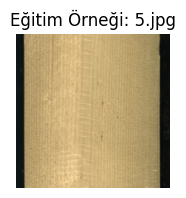


Örnek kusurlu test verisi ve maskesi:
Batch image shape: torch.Size([16, 3, 256, 256]), mask shape: torch.Size([16, 1, 256, 256])


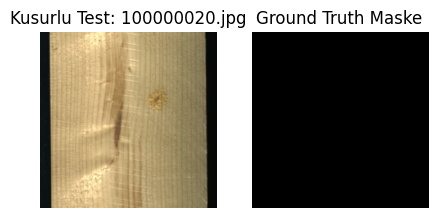


Örnek normal test verisi:
Batch shape: torch.Size([16, 3, 256, 256])


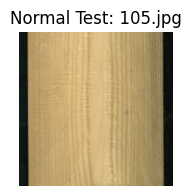

In [66]:
# Veri Yükleyicilerin Oluşturulması

def get_image_paths(directory, extensions=('.jpg', '.jpeg', '.png')):
    """Belirtilen dizindeki tüm resim dosyalarının yollarını alır."""
    paths = []
    if not os.path.isdir(directory):
        print(f"Uyarı: Dizin bulunamadı veya geçerli değil: {directory}")
        return paths
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                paths.append(os.path.join(root, file))
    return paths

# Veri seti yolları
train_good_dir = os.path.join(DATASET_PATH, "train", "good")
test_good_dir = os.path.join(DATASET_PATH, "test", "good")
test_defect_dir = os.path.join(DATASET_PATH, "test", "defect")
ground_truth_defect_dir = os.path.join(DATASET_PATH, "ground_truth", "defect")

# Dosya yollarını al
train_good_paths = get_image_paths(train_good_dir)
test_good_paths = get_image_paths(test_good_dir)
test_defect_paths = get_image_paths(test_defect_dir)

print(f"Eğitim için normal görüntü sayısı: {len(train_good_paths)}")
print(f"Test için normal görüntü sayısı: {len(test_good_paths)}")
print(f"Test için kusurlu görüntü sayısı: {len(test_defect_paths)}")

# Veri setlerini oluştur
train_dataset = WoodDataset(image_paths=train_good_paths, transform=transform)
test_good_dataset = WoodDataset(image_paths=test_good_paths, transform=transform)
test_defect_dataset = WoodDataset(image_paths=test_defect_paths, transform=transform,
                                  is_test_defect=True, ground_truth_dir=ground_truth_defect_dir)

# Veri yükleyicilerini oluştur
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # num_workers=0 Windows'ta bazen daha stabil
test_good_loader = DataLoader(test_good_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_defect_loader = DataLoader(test_defect_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# Birkaç örnek görüntü ve maskeyi kontrol edelim (veri varsa)
def show_sample_data():
    print("\nÖrnek eğitim verisi:")
    if len(train_dataset) > 0:
        images, _, paths = next(iter(train_loader))
        print(f"Batch shape: {images.shape}")
        plt.figure(figsize=(2,2))
        plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Eğitim Örneği: {os.path.basename(paths[0])}")
        plt.axis('off')
        plt.show()
    else:
        print("Eğitim verisi bulunamadı.")

    if len(test_defect_dataset) > 0:
        print("\nÖrnek kusurlu test verisi ve maskesi:")
        images, masks, paths = next(iter(test_defect_loader))
        if images.nelement() > 0 and masks.nelement() > 0:
            print(f"Batch image shape: {images.shape}, mask shape: {masks.shape}")
            fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
            axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title(f"Kusurlu Test: {os.path.basename(paths[0])}")
            axes[0].axis('off')
            axes[1].imshow(masks[0].squeeze().cpu().numpy(), cmap='gray')
            axes[1].set_title("Ground Truth Maske")
            axes[1].axis('off')
            plt.show()
        else:
            print("Kusurlu test verisi veya maskesi yüklenirken sorun oluştu.")
    else:
        print("Kusurlu test verisi bulunamadı.")

    if len(test_good_dataset) > 0:
        print("\nÖrnek normal test verisi:")
        images, _, paths = next(iter(test_good_loader))
        print(f"Batch shape: {images.shape}")
        plt.figure(figsize=(2,2))
        plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Normal Test: {os.path.basename(paths[0])}")
        plt.axis('off')
        plt.show()
    else:
        print("Normal test verisi bulunamadı.")

if len(train_good_paths) > 0 or len(test_good_paths) > 0 or len(test_defect_paths) > 0:
    show_sample_data()
else:
    print("Gösterilecek veri bulunamadı. Lütfen DATASET_PATH'i kontrol edin.")

In [67]:
# ========================== MODELLER ==========================
# 1. Autoencoder Modeli (Basitleştirilmiş)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 256x256x3 -> 128x128x32
        self.enc2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) # 128x128x32 -> 64x64x64
        self.enc3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)# 64x64x64 -> 32x32x128 (latent)

        # Decoder
        self.dec3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1) # 32x32x128 -> 64x64x64
        self.dec2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1) # 64x64x64 -> 128x128x32
        self.dec1 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128x32 -> 256x256x3

    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x)) # Latent space
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec2(x))
        reconstructed = torch.sigmoid(self.dec1(x)) # [0,1] aralığı için sigmoid
        return reconstructed

# 2. Hafif Evrişimli Autoencoder (Lightweight Convolutional Autoencoder)
class LCAE(nn.Module):
    def __init__(self):
        super(LCAE, self).__init__()
        # Encoder - daha az filtre ve daha sığ yapı
        self.enc1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)  # 256x256x3 -> 128x128x16
        self.enc2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2) # 128x128x16 -> 64x64x32

        # Decoder
        self.dec2 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1) # 64x64x32 -> 128x128x16
        self.dec1 = nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1)  # 128x128x16 -> 256x256x3

    def forward(self, x):
        # Encoder
        x = F.leaky_relu(self.enc1(x), 0.2)
        latent = F.leaky_relu(self.enc2(x), 0.2)
        # Decoder
        x = F.leaky_relu(self.dec2(latent), 0.2)
        reconstructed = torch.sigmoid(self.dec1(x))
        return reconstructed

# 3. PatchCore benzeri hafıza bankası yaklaşımı
class MemoryBankModel(nn.Module):
    def __init__(self, feature_dim=32):
        super(MemoryBankModel, self).__init__()
        # Basit bir özellik çıkarıcı
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, feature_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Hafıza bankası yerine otokodlayıcı
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        reconstructed = self.decoder(features)
        return reconstructed

# Modelleri test edelim (dummy input ile)
dummy_input = torch.randn(2, 3, IMG_SIZE[0], IMG_SIZE[1]).to(device)

print("\nModel Testleri:")
try:
    ae_model = Autoencoder().to(device)
    ae_output = ae_model(dummy_input)
    print(f"Autoencoder input shape: {dummy_input.shape}, output shape: {ae_output.shape}")
    assert ae_output.shape == dummy_input.shape, "Autoencoder output shape mismatch!"
except Exception as e:
    print(f"Autoencoder hata: {e}")

try:
    lcae_model = LCAE().to(device)
    lcae_output = lcae_model(dummy_input)
    print(f"LCAE input shape: {dummy_input.shape}, output shape: {lcae_output.shape}")
    assert lcae_output.shape == dummy_input.shape, "LCAE output shape mismatch!"
except Exception as e:
    print(f"LCAE hata: {e}")

try:
    mb_model = MemoryBankModel().to(device)
    mb_output = mb_model(dummy_input)
    print(f"MemoryBank input shape: {dummy_input.shape}, output shape: {mb_output.shape}")
    assert mb_output.shape == dummy_input.shape, "MemoryBank output shape mismatch!"
except Exception as e:
    print(f"MemoryBank hata: {e}")


Model Testleri:
Autoencoder input shape: torch.Size([2, 3, 256, 256]), output shape: torch.Size([2, 3, 256, 256])
LCAE input shape: torch.Size([2, 3, 256, 256]), output shape: torch.Size([2, 3, 256, 256])
MemoryBank input shape: torch.Size([2, 3, 256, 256]), output shape: torch.Size([2, 3, 256, 256])


In [68]:
# ========================== MODEL VE OPTİMİZER TANIMLARI ==========================
# Modellerin, Kayıp Fonksiyonlarının ve Optimizatörlerin Başlatılması

models_dict = {
    "Autoencoder": Autoencoder().to(device),
    "LCAE": LCAE().to(device),
    "MemoryBankModel": MemoryBankModel().to(device)
}

criterions = {name: nn.MSELoss().to(device) for name in models_dict.keys()}
optimizers = {
    name: optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for name, model in models_dict.items()
}

print("Modeller, kayıp fonksiyonları ve optimizatörler hazır.")

Modeller, kayıp fonksiyonları ve optimizatörler hazır.


--- Autoencoder Modeli Eğitimi Başlıyor ---
Epoch [1/50], Batch [1/5], Anlık Kayıp: 0.0620
Epoch [1/50], Batch [2/5], Anlık Kayıp: 0.0611
Epoch [1/50], Batch [3/5], Anlık Kayıp: 0.0622
Epoch [1/50], Batch [4/5], Anlık Kayıp: 0.0665
Epoch [1/50], Batch [5/5], Anlık Kayıp: 0.0588
Epoch [1/50] tamamlandı. Ortalama Eğitim Kaybı: 0.062588
Epoch [2/50], Batch [1/5], Anlık Kayıp: 0.0683
Epoch [2/50], Batch [2/5], Anlık Kayıp: 0.0617
Epoch [2/50], Batch [3/5], Anlık Kayıp: 0.0558
Epoch [2/50], Batch [4/5], Anlık Kayıp: 0.0640
Epoch [2/50], Batch [5/5], Anlık Kayıp: 0.0622
Epoch [2/50] tamamlandı. Ortalama Eğitim Kaybı: 0.062413
Epoch [3/50], Batch [1/5], Anlık Kayıp: 0.0638
Epoch [3/50], Batch [2/5], Anlık Kayıp: 0.0595
Epoch [3/50], Batch [3/5], Anlık Kayıp: 0.0654
Epoch [3/50], Batch [4/5], Anlık Kayıp: 0.0587
Epoch [3/50], Batch [5/5], Anlık Kayıp: 0.0666
Epoch [3/50] tamamlandı. Ortalama Eğitim Kaybı: 0.062245
Epoch [4/50], Batch [1/5], Anlık Kayıp: 0.0614
Epoch [4/50], Batch [2/5], Anlık 

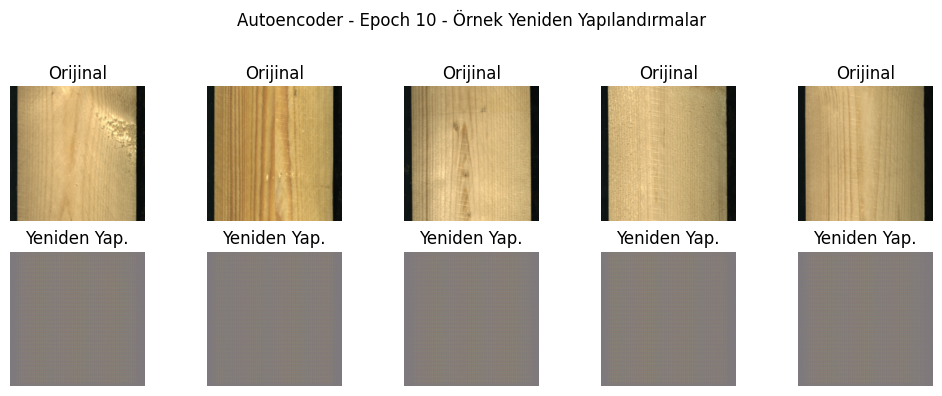

Epoch [11/50], Batch [1/5], Anlık Kayıp: 0.0557
Epoch [11/50], Batch [2/5], Anlık Kayıp: 0.0546
Epoch [11/50], Batch [3/5], Anlık Kayıp: 0.0535
Epoch [11/50], Batch [4/5], Anlık Kayıp: 0.0565
Epoch [11/50], Batch [5/5], Anlık Kayıp: 0.0524
Epoch [11/50] tamamlandı. Ortalama Eğitim Kaybı: 0.054824
Epoch [12/50], Batch [1/5], Anlık Kayıp: 0.0519
Epoch [12/50], Batch [2/5], Anlık Kayıp: 0.0506
Epoch [12/50], Batch [3/5], Anlık Kayıp: 0.0504
Epoch [12/50], Batch [4/5], Anlık Kayıp: 0.0536
Epoch [12/50], Batch [5/5], Anlık Kayıp: 0.0489
Epoch [12/50] tamamlandı. Ortalama Eğitim Kaybı: 0.051416
Epoch [13/50], Batch [1/5], Anlık Kayıp: 0.0488
Epoch [13/50], Batch [2/5], Anlık Kayıp: 0.0484
Epoch [13/50], Batch [3/5], Anlık Kayıp: 0.0489
Epoch [13/50], Batch [4/5], Anlık Kayıp: 0.0460
Epoch [13/50], Batch [5/5], Anlık Kayıp: 0.0447
Epoch [13/50] tamamlandı. Ortalama Eğitim Kaybı: 0.047779
Epoch [14/50], Batch [1/5], Anlık Kayıp: 0.0483
Epoch [14/50], Batch [2/5], Anlık Kayıp: 0.0451
Epoch [14/

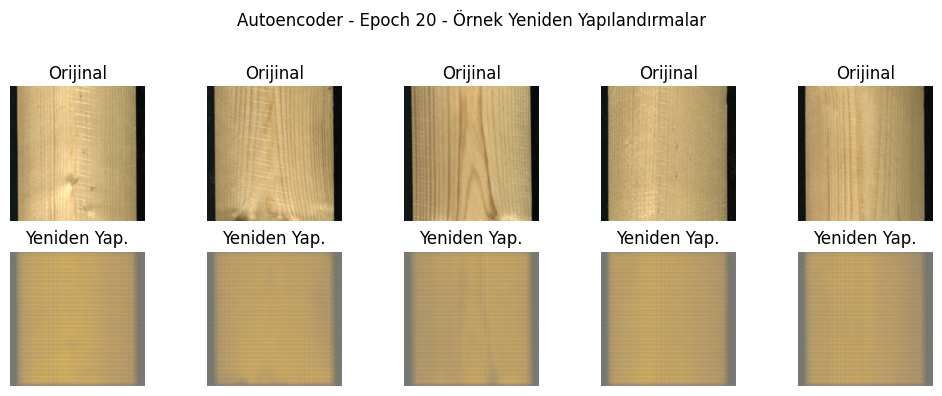

Epoch [21/50], Batch [1/5], Anlık Kayıp: 0.0285
Epoch [21/50], Batch [2/5], Anlık Kayıp: 0.0287
Epoch [21/50], Batch [3/5], Anlık Kayıp: 0.0317
Epoch [21/50], Batch [4/5], Anlık Kayıp: 0.0267
Epoch [21/50], Batch [5/5], Anlık Kayıp: 0.0256
Epoch [21/50] tamamlandı. Ortalama Eğitim Kaybı: 0.028629
Epoch [22/50], Batch [1/5], Anlık Kayıp: 0.0300
Epoch [22/50], Batch [2/5], Anlık Kayıp: 0.0262
Epoch [22/50], Batch [3/5], Anlık Kayıp: 0.0246
Epoch [22/50], Batch [4/5], Anlık Kayıp: 0.0252
Epoch [22/50], Batch [5/5], Anlık Kayıp: 0.0261
Epoch [22/50] tamamlandı. Ortalama Eğitim Kaybı: 0.026477
Epoch [23/50], Batch [1/5], Anlık Kayıp: 0.0237
Epoch [23/50], Batch [2/5], Anlık Kayıp: 0.0246
Epoch [23/50], Batch [3/5], Anlık Kayıp: 0.0259
Epoch [23/50], Batch [4/5], Anlık Kayıp: 0.0233
Epoch [23/50], Batch [5/5], Anlık Kayıp: 0.0236
Epoch [23/50] tamamlandı. Ortalama Eğitim Kaybı: 0.024286
Epoch [24/50], Batch [1/5], Anlık Kayıp: 0.0225
Epoch [24/50], Batch [2/5], Anlık Kayıp: 0.0217
Epoch [24/

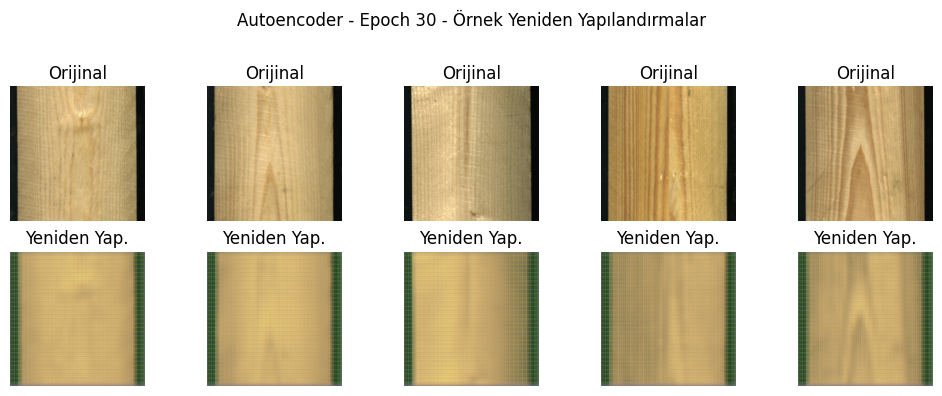

Epoch [31/50], Batch [1/5], Anlık Kayıp: 0.0133
Epoch [31/50], Batch [2/5], Anlık Kayıp: 0.0117
Epoch [31/50], Batch [3/5], Anlık Kayıp: 0.0116
Epoch [31/50], Batch [4/5], Anlık Kayıp: 0.0112
Epoch [31/50], Batch [5/5], Anlık Kayıp: 0.0111
Epoch [31/50] tamamlandı. Ortalama Eğitim Kaybı: 0.011863
Epoch [32/50], Batch [1/5], Anlık Kayıp: 0.0106
Epoch [32/50], Batch [2/5], Anlık Kayıp: 0.0111
Epoch [32/50], Batch [3/5], Anlık Kayıp: 0.0103
Epoch [32/50], Batch [4/5], Anlık Kayıp: 0.0114
Epoch [32/50], Batch [5/5], Anlık Kayıp: 0.0100
Epoch [32/50] tamamlandı. Ortalama Eğitim Kaybı: 0.010799
Epoch [33/50], Batch [1/5], Anlık Kayıp: 0.0099
Epoch [33/50], Batch [2/5], Anlık Kayıp: 0.0108
Epoch [33/50], Batch [3/5], Anlık Kayıp: 0.0098
Epoch [33/50], Batch [4/5], Anlık Kayıp: 0.0094
Epoch [33/50], Batch [5/5], Anlık Kayıp: 0.0090
Epoch [33/50] tamamlandı. Ortalama Eğitim Kaybı: 0.009883
Epoch [34/50], Batch [1/5], Anlık Kayıp: 0.0091
Epoch [34/50], Batch [2/5], Anlık Kayıp: 0.0089
Epoch [34/

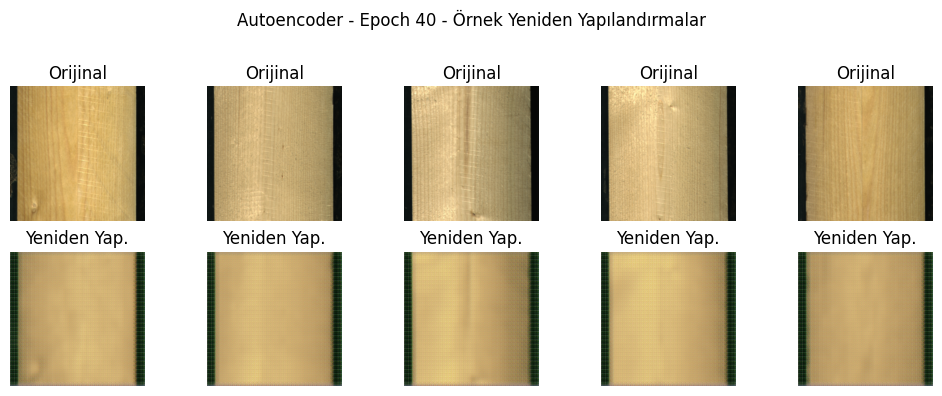

Epoch [41/50], Batch [1/5], Anlık Kayıp: 0.0050
Epoch [41/50], Batch [2/5], Anlık Kayıp: 0.0051
Epoch [41/50], Batch [3/5], Anlık Kayıp: 0.0049
Epoch [41/50], Batch [4/5], Anlık Kayıp: 0.0050
Epoch [41/50], Batch [5/5], Anlık Kayıp: 0.0057
Epoch [41/50] tamamlandı. Ortalama Eğitim Kaybı: 0.005065
Epoch [42/50], Batch [1/5], Anlık Kayıp: 0.0048
Epoch [42/50], Batch [2/5], Anlık Kayıp: 0.0051
Epoch [42/50], Batch [3/5], Anlık Kayıp: 0.0047
Epoch [42/50], Batch [4/5], Anlık Kayıp: 0.0046
Epoch [42/50], Batch [5/5], Anlık Kayıp: 0.0043
Epoch [42/50] tamamlandı. Ortalama Eğitim Kaybı: 0.004750
Epoch [43/50], Batch [1/5], Anlık Kayıp: 0.0043
Epoch [43/50], Batch [2/5], Anlık Kayıp: 0.0046
Epoch [43/50], Batch [3/5], Anlık Kayıp: 0.0046
Epoch [43/50], Batch [4/5], Anlık Kayıp: 0.0043
Epoch [43/50], Batch [5/5], Anlık Kayıp: 0.0042
Epoch [43/50] tamamlandı. Ortalama Eğitim Kaybı: 0.004440
Epoch [44/50], Batch [1/5], Anlık Kayıp: 0.0042
Epoch [44/50], Batch [2/5], Anlık Kayıp: 0.0045
Epoch [44/

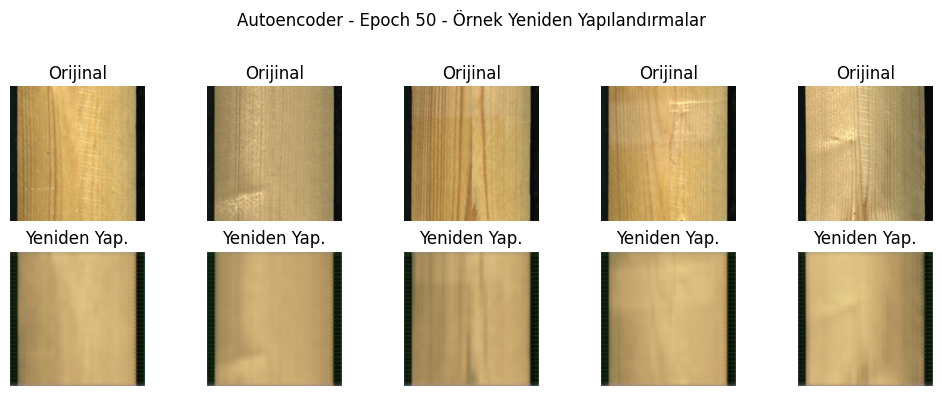

--- Autoencoder Modeli Eğitimi Tamamlandı ---


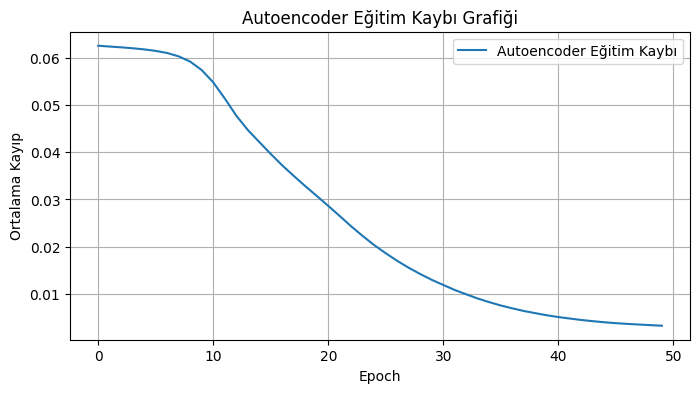

--- LCAE Modeli Eğitimi Başlıyor ---
Epoch [1/50], Batch [1/5], Anlık Kayıp: 0.0550
Epoch [1/50], Batch [2/5], Anlık Kayıp: 0.0604
Epoch [1/50], Batch [3/5], Anlık Kayıp: 0.0603
Epoch [1/50], Batch [4/5], Anlık Kayıp: 0.0613
Epoch [1/50], Batch [5/5], Anlık Kayıp: 0.0591
Epoch [1/50] tamamlandı. Ortalama Eğitim Kaybı: 0.059218
Epoch [2/50], Batch [1/5], Anlık Kayıp: 0.0571
Epoch [2/50], Batch [2/5], Anlık Kayıp: 0.0598
Epoch [2/50], Batch [3/5], Anlık Kayıp: 0.0586
Epoch [2/50], Batch [4/5], Anlık Kayıp: 0.0620
Epoch [2/50], Batch [5/5], Anlık Kayıp: 0.0530
Epoch [2/50] tamamlandı. Ortalama Eğitim Kaybı: 0.058824
Epoch [3/50], Batch [1/5], Anlık Kayıp: 0.0569
Epoch [3/50], Batch [2/5], Anlık Kayıp: 0.0621
Epoch [3/50], Batch [3/5], Anlık Kayıp: 0.0602
Epoch [3/50], Batch [4/5], Anlık Kayıp: 0.0556
Epoch [3/50], Batch [5/5], Anlık Kayıp: 0.0550
Epoch [3/50] tamamlandı. Ortalama Eğitim Kaybı: 0.058408
Epoch [4/50], Batch [1/5], Anlık Kayıp: 0.0580
Epoch [4/50], Batch [2/5], Anlık Kayıp: 

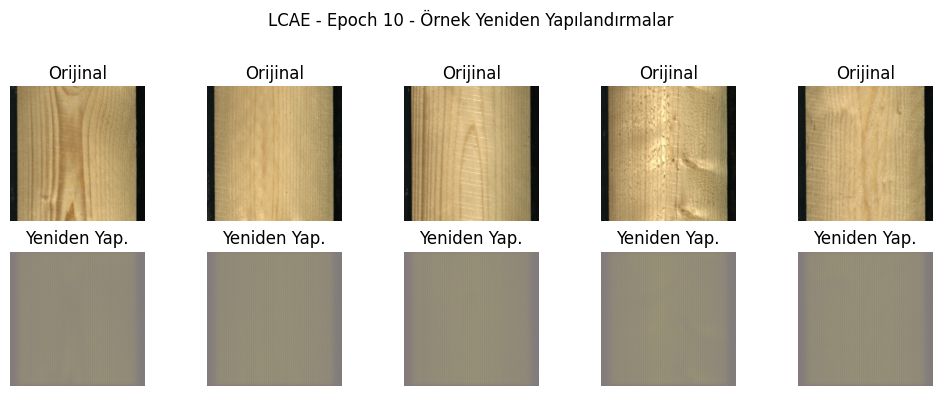

Epoch [11/50], Batch [1/5], Anlık Kayıp: 0.0435
Epoch [11/50], Batch [2/5], Anlık Kayıp: 0.0432
Epoch [11/50], Batch [3/5], Anlık Kayıp: 0.0446
Epoch [11/50], Batch [4/5], Anlık Kayıp: 0.0465
Epoch [11/50], Batch [5/5], Anlık Kayıp: 0.0392
Epoch [11/50] tamamlandı. Ortalama Eğitim Kaybı: 0.044001
Epoch [12/50], Batch [1/5], Anlık Kayıp: 0.0422
Epoch [12/50], Batch [2/5], Anlık Kayıp: 0.0400
Epoch [12/50], Batch [3/5], Anlık Kayıp: 0.0382
Epoch [12/50], Batch [4/5], Anlık Kayıp: 0.0415
Epoch [12/50], Batch [5/5], Anlık Kayıp: 0.0411
Epoch [12/50] tamamlandı. Ortalama Eğitim Kaybı: 0.040526
Epoch [13/50], Batch [1/5], Anlık Kayıp: 0.0398
Epoch [13/50], Batch [2/5], Anlık Kayıp: 0.0370
Epoch [13/50], Batch [3/5], Anlık Kayıp: 0.0390
Epoch [13/50], Batch [4/5], Anlık Kayıp: 0.0361
Epoch [13/50], Batch [5/5], Anlık Kayıp: 0.0334
Epoch [13/50] tamamlandı. Ortalama Eğitim Kaybı: 0.037578
Epoch [14/50], Batch [1/5], Anlık Kayıp: 0.0346
Epoch [14/50], Batch [2/5], Anlık Kayıp: 0.0346
Epoch [14/

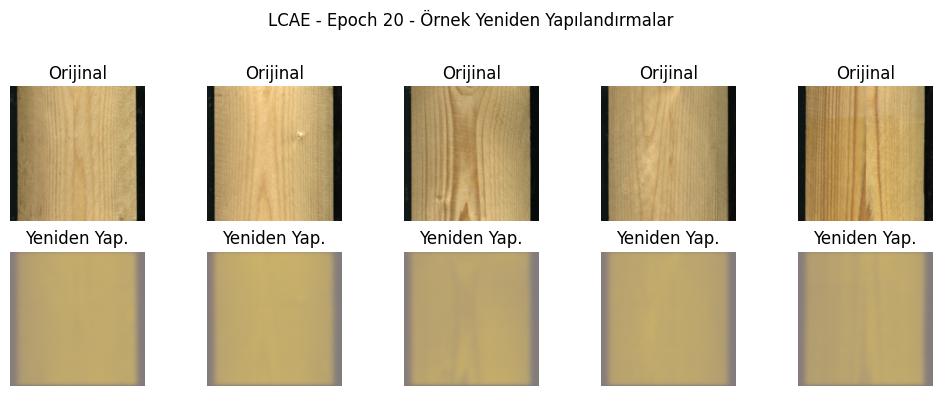

Epoch [21/50], Batch [1/5], Anlık Kayıp: 0.0287
Epoch [21/50], Batch [2/5], Anlık Kayıp: 0.0332
Epoch [21/50], Batch [3/5], Anlık Kayıp: 0.0300
Epoch [21/50], Batch [4/5], Anlık Kayıp: 0.0292
Epoch [21/50], Batch [5/5], Anlık Kayıp: 0.0300
Epoch [21/50] tamamlandı. Ortalama Eğitim Kaybı: 0.030241
Epoch [22/50], Batch [1/5], Anlık Kayıp: 0.0290
Epoch [22/50], Batch [2/5], Anlık Kayıp: 0.0290
Epoch [22/50], Batch [3/5], Anlık Kayıp: 0.0331
Epoch [22/50], Batch [4/5], Anlık Kayıp: 0.0288
Epoch [22/50], Batch [5/5], Anlık Kayıp: 0.0310
Epoch [22/50] tamamlandı. Ortalama Eğitim Kaybı: 0.030054
Epoch [23/50], Batch [1/5], Anlık Kayıp: 0.0329
Epoch [23/50], Batch [2/5], Anlık Kayıp: 0.0294
Epoch [23/50], Batch [3/5], Anlık Kayıp: 0.0291
Epoch [23/50], Batch [4/5], Anlık Kayıp: 0.0288
Epoch [23/50], Batch [5/5], Anlık Kayıp: 0.0284
Epoch [23/50] tamamlandı. Ortalama Eğitim Kaybı: 0.029897
Epoch [24/50], Batch [1/5], Anlık Kayıp: 0.0289
Epoch [24/50], Batch [2/5], Anlık Kayıp: 0.0289
Epoch [24/

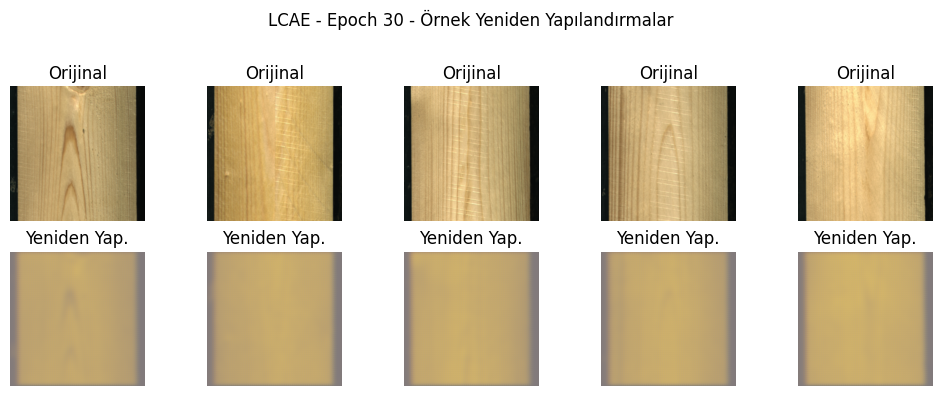

Epoch [31/50], Batch [1/5], Anlık Kayıp: 0.0277
Epoch [31/50], Batch [2/5], Anlık Kayıp: 0.0329
Epoch [31/50], Batch [3/5], Anlık Kayıp: 0.0277
Epoch [31/50], Batch [4/5], Anlık Kayıp: 0.0280
Epoch [31/50], Batch [5/5], Anlık Kayıp: 0.0283
Epoch [31/50] tamamlandı. Ortalama Eğitim Kaybı: 0.029010
Epoch [32/50], Batch [1/5], Anlık Kayıp: 0.0315
Epoch [32/50], Batch [2/5], Anlık Kayıp: 0.0284
Epoch [32/50], Batch [3/5], Anlık Kayıp: 0.0283
Epoch [32/50], Batch [4/5], Anlık Kayıp: 0.0279
Epoch [32/50], Batch [5/5], Anlık Kayıp: 0.0273
Epoch [32/50] tamamlandı. Ortalama Eğitim Kaybı: 0.028907
Epoch [33/50], Batch [1/5], Anlık Kayıp: 0.0325
Epoch [33/50], Batch [2/5], Anlık Kayıp: 0.0270
Epoch [33/50], Batch [3/5], Anlık Kayıp: 0.0282
Epoch [33/50], Batch [4/5], Anlık Kayıp: 0.0281
Epoch [33/50], Batch [5/5], Anlık Kayıp: 0.0274
Epoch [33/50] tamamlandı. Ortalama Eğitim Kaybı: 0.028793
Epoch [34/50], Batch [1/5], Anlık Kayıp: 0.0278
Epoch [34/50], Batch [2/5], Anlık Kayıp: 0.0274
Epoch [34/

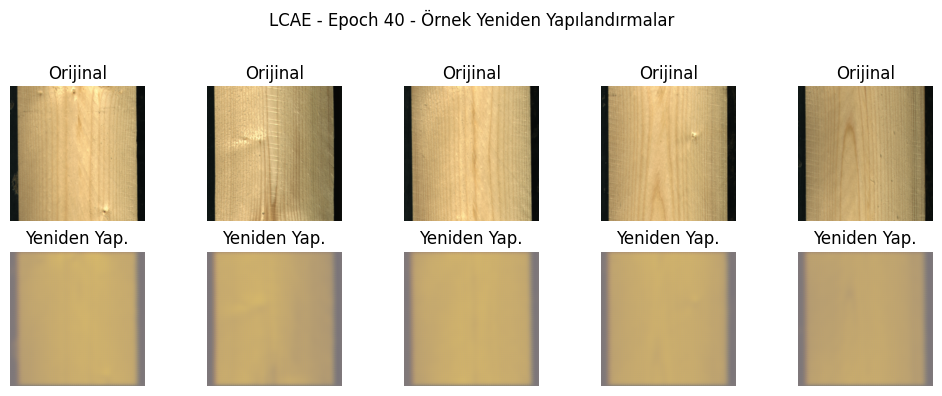

Epoch [41/50], Batch [1/5], Anlık Kayıp: 0.0266
Epoch [41/50], Batch [2/5], Anlık Kayıp: 0.0268
Epoch [41/50], Batch [3/5], Anlık Kayıp: 0.0303
Epoch [41/50], Batch [4/5], Anlık Kayıp: 0.0260
Epoch [41/50], Batch [5/5], Anlık Kayıp: 0.0256
Epoch [41/50] tamamlandı. Ortalama Eğitim Kaybı: 0.027267
Epoch [42/50], Batch [1/5], Anlık Kayıp: 0.0261
Epoch [42/50], Batch [2/5], Anlık Kayıp: 0.0263
Epoch [42/50], Batch [3/5], Anlık Kayıp: 0.0297
Epoch [42/50], Batch [4/5], Anlık Kayıp: 0.0261
Epoch [42/50], Batch [5/5], Anlık Kayıp: 0.0256
Epoch [42/50] tamamlandı. Ortalama Eğitim Kaybı: 0.026934
Epoch [43/50], Batch [1/5], Anlık Kayıp: 0.0299
Epoch [43/50], Batch [2/5], Anlık Kayıp: 0.0257
Epoch [43/50], Batch [3/5], Anlık Kayıp: 0.0257
Epoch [43/50], Batch [4/5], Anlık Kayıp: 0.0253
Epoch [43/50], Batch [5/5], Anlık Kayıp: 0.0255
Epoch [43/50] tamamlandı. Ortalama Eğitim Kaybı: 0.026566
Epoch [44/50], Batch [1/5], Anlık Kayıp: 0.0294
Epoch [44/50], Batch [2/5], Anlık Kayıp: 0.0257
Epoch [44/

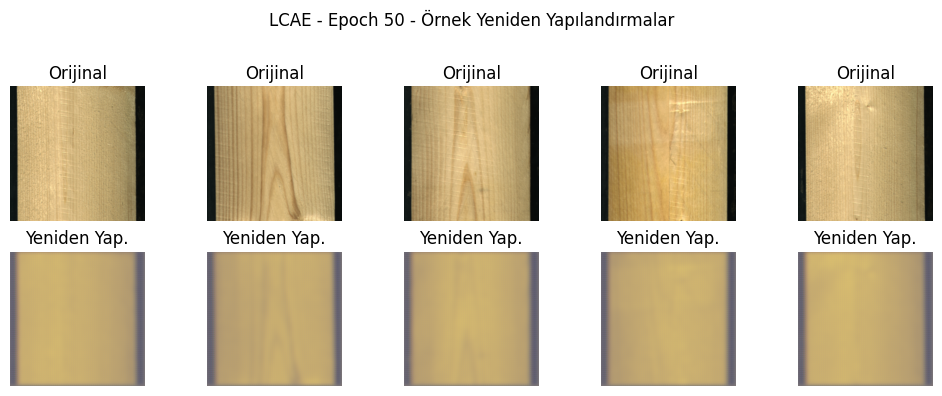

--- LCAE Modeli Eğitimi Tamamlandı ---


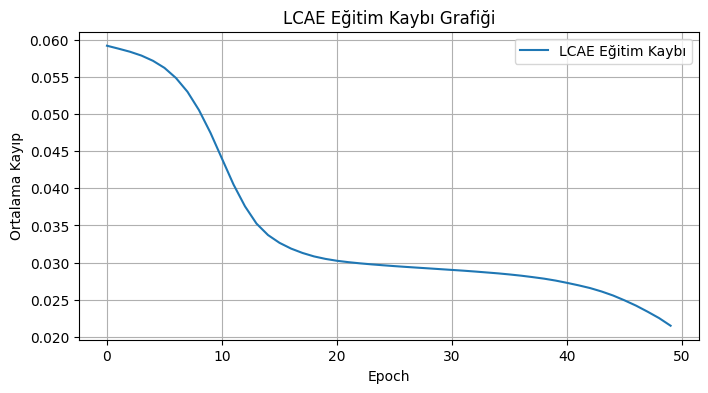

--- MemoryBankModel Modeli Eğitimi Başlıyor ---
Epoch [1/50], Batch [1/5], Anlık Kayıp: 0.0559
Epoch [1/50], Batch [2/5], Anlık Kayıp: 0.0503
Epoch [1/50], Batch [3/5], Anlık Kayıp: 0.0544
Epoch [1/50], Batch [4/5], Anlık Kayıp: 0.0487
Epoch [1/50], Batch [5/5], Anlık Kayıp: 0.0451
Epoch [1/50] tamamlandı. Ortalama Eğitim Kaybı: 0.051723
Epoch [2/50], Batch [1/5], Anlık Kayıp: 0.0559
Epoch [2/50], Batch [2/5], Anlık Kayıp: 0.0491
Epoch [2/50], Batch [3/5], Anlık Kayıp: 0.0491
Epoch [2/50], Batch [4/5], Anlık Kayıp: 0.0533
Epoch [2/50], Batch [5/5], Anlık Kayıp: 0.0480
Epoch [2/50] tamamlandı. Ortalama Eğitim Kaybı: 0.051536
Epoch [3/50], Batch [1/5], Anlık Kayıp: 0.0508
Epoch [3/50], Batch [2/5], Anlık Kayıp: 0.0501
Epoch [3/50], Batch [3/5], Anlık Kayıp: 0.0551
Epoch [3/50], Batch [4/5], Anlık Kayıp: 0.0503
Epoch [3/50], Batch [5/5], Anlık Kayıp: 0.0492
Epoch [3/50] tamamlandı. Ortalama Eğitim Kaybı: 0.051351
Epoch [4/50], Batch [1/5], Anlık Kayıp: 0.0557
Epoch [4/50], Batch [2/5], An

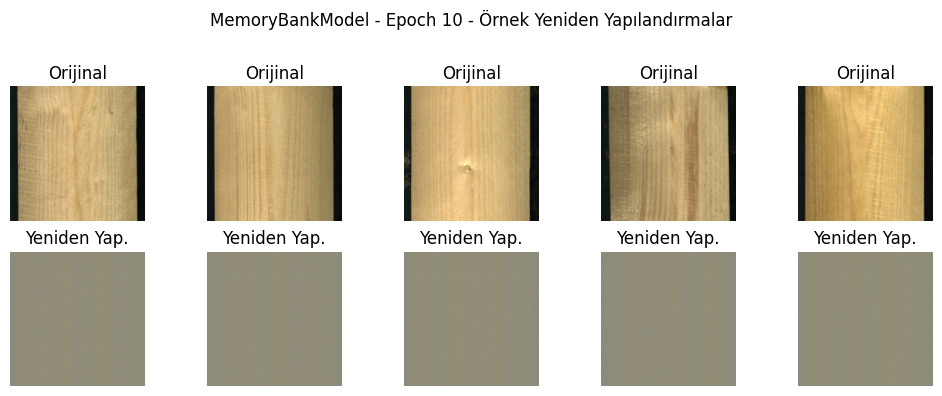

Epoch [11/50], Batch [1/5], Anlık Kayıp: 0.0505
Epoch [11/50], Batch [2/5], Anlık Kayıp: 0.0534
Epoch [11/50], Batch [3/5], Anlık Kayıp: 0.0483
Epoch [11/50], Batch [4/5], Anlık Kayıp: 0.0458
Epoch [11/50], Batch [5/5], Anlık Kayıp: 0.0473
Epoch [11/50] tamamlandı. Ortalama Eğitim Kaybı: 0.049304
Epoch [12/50], Batch [1/5], Anlık Kayıp: 0.0496
Epoch [12/50], Batch [2/5], Anlık Kayıp: 0.0506
Epoch [12/50], Batch [3/5], Anlık Kayıp: 0.0493
Epoch [12/50], Batch [4/5], Anlık Kayıp: 0.0466
Epoch [12/50], Batch [5/5], Anlık Kayıp: 0.0483
Epoch [12/50] tamamlandı. Ortalama Eğitim Kaybı: 0.048964
Epoch [13/50], Batch [1/5], Anlık Kayıp: 0.0500
Epoch [13/50], Batch [2/5], Anlık Kayıp: 0.0469
Epoch [13/50], Batch [3/5], Anlık Kayıp: 0.0521
Epoch [13/50], Batch [4/5], Anlık Kayıp: 0.0477
Epoch [13/50], Batch [5/5], Anlık Kayıp: 0.0428
Epoch [13/50] tamamlandı. Ortalama Eğitim Kaybı: 0.048617
Epoch [14/50], Batch [1/5], Anlık Kayıp: 0.0541
Epoch [14/50], Batch [2/5], Anlık Kayıp: 0.0466
Epoch [14/

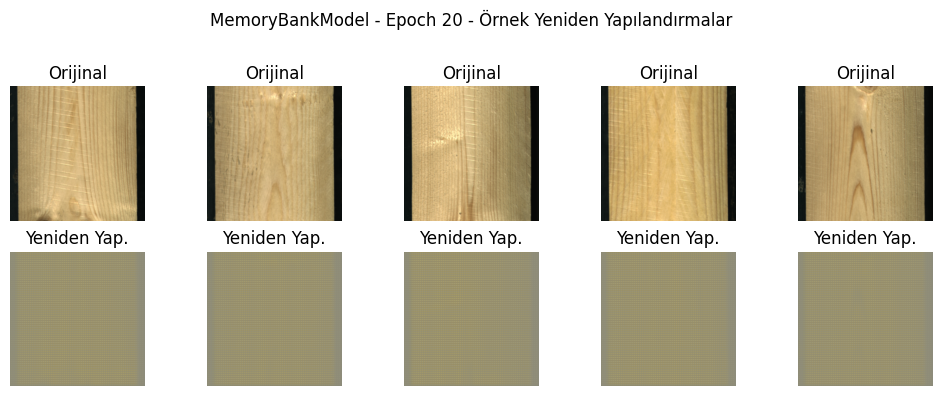

Epoch [21/50], Batch [1/5], Anlık Kayıp: 0.0424
Epoch [21/50], Batch [2/5], Anlık Kayıp: 0.0510
Epoch [21/50], Batch [3/5], Anlık Kayıp: 0.0462
Epoch [21/50], Batch [4/5], Anlık Kayıp: 0.0450
Epoch [21/50], Batch [5/5], Anlık Kayıp: 0.0423
Epoch [21/50] tamamlandı. Ortalama Eğitim Kaybı: 0.045812
Epoch [22/50], Batch [1/5], Anlık Kayıp: 0.0484
Epoch [22/50], Batch [2/5], Anlık Kayıp: 0.0447
Epoch [22/50], Batch [3/5], Anlık Kayıp: 0.0445
Epoch [22/50], Batch [4/5], Anlık Kayıp: 0.0446
Epoch [22/50], Batch [5/5], Anlık Kayıp: 0.0445
Epoch [22/50] tamamlandı. Ortalama Eğitim Kaybı: 0.045489
Epoch [23/50], Batch [1/5], Anlık Kayıp: 0.0453
Epoch [23/50], Batch [2/5], Anlık Kayıp: 0.0482
Epoch [23/50], Batch [3/5], Anlık Kayıp: 0.0436
Epoch [23/50], Batch [4/5], Anlık Kayıp: 0.0425
Epoch [23/50], Batch [5/5], Anlık Kayıp: 0.0477
Epoch [23/50] tamamlandı. Ortalama Eğitim Kaybı: 0.045171
Epoch [24/50], Batch [1/5], Anlık Kayıp: 0.0441
Epoch [24/50], Batch [2/5], Anlık Kayıp: 0.0409
Epoch [24/

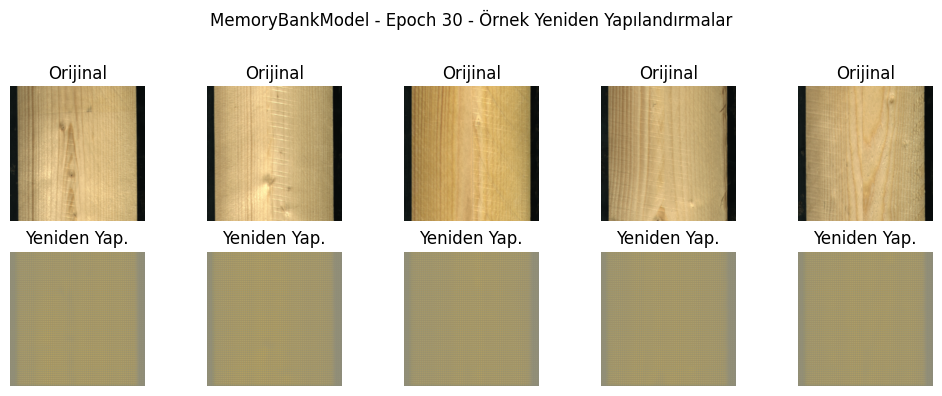

Epoch [31/50], Batch [1/5], Anlık Kayıp: 0.0495
Epoch [31/50], Batch [2/5], Anlık Kayıp: 0.0388
Epoch [31/50], Batch [3/5], Anlık Kayıp: 0.0419
Epoch [31/50], Batch [4/5], Anlık Kayıp: 0.0415
Epoch [31/50], Batch [5/5], Anlık Kayıp: 0.0407
Epoch [31/50] tamamlandı. Ortalama Eğitim Kaybı: 0.042740
Epoch [32/50], Batch [1/5], Anlık Kayıp: 0.0409
Epoch [32/50], Batch [2/5], Anlık Kayıp: 0.0422
Epoch [32/50], Batch [3/5], Anlık Kayıp: 0.0407
Epoch [32/50], Batch [4/5], Anlık Kayıp: 0.0464
Epoch [32/50], Batch [5/5], Anlık Kayıp: 0.0414
Epoch [32/50] tamamlandı. Ortalama Eğitim Kaybı: 0.042433
Epoch [33/50], Batch [1/5], Anlık Kayıp: 0.0422
Epoch [33/50], Batch [2/5], Anlık Kayıp: 0.0413
Epoch [33/50], Batch [3/5], Anlık Kayıp: 0.0397
Epoch [33/50], Batch [4/5], Anlık Kayıp: 0.0461
Epoch [33/50], Batch [5/5], Anlık Kayıp: 0.0401
Epoch [33/50] tamamlandı. Ortalama Eğitim Kaybı: 0.042129
Epoch [34/50], Batch [1/5], Anlık Kayıp: 0.0405
Epoch [34/50], Batch [2/5], Anlık Kayıp: 0.0434
Epoch [34/

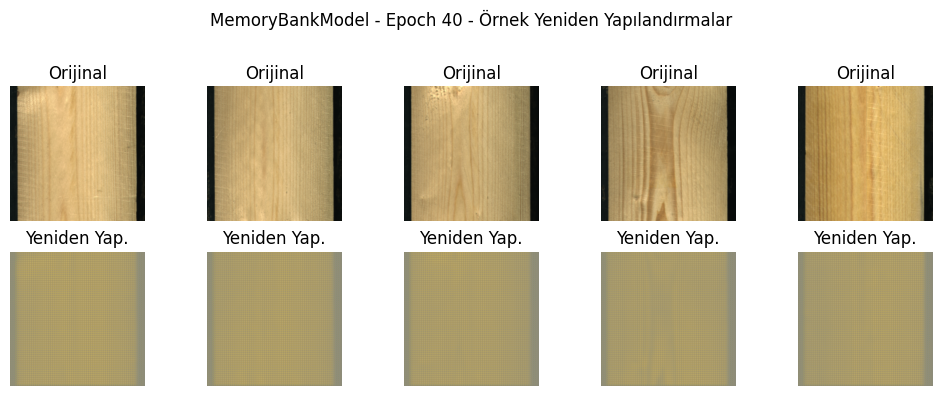

Epoch [41/50], Batch [1/5], Anlık Kayıp: 0.0385
Epoch [41/50], Batch [2/5], Anlık Kayıp: 0.0387
Epoch [41/50], Batch [3/5], Anlık Kayıp: 0.0433
Epoch [41/50], Batch [4/5], Anlık Kayıp: 0.0382
Epoch [41/50], Batch [5/5], Anlık Kayıp: 0.0355
Epoch [41/50] tamamlandı. Ortalama Eğitim Kaybı: 0.039308
Epoch [42/50], Batch [1/5], Anlık Kayıp: 0.0397
Epoch [42/50], Batch [2/5], Anlık Kayıp: 0.0378
Epoch [42/50], Batch [3/5], Anlık Kayıp: 0.0360
Epoch [42/50], Batch [4/5], Anlık Kayıp: 0.0427
Epoch [42/50], Batch [5/5], Anlık Kayıp: 0.0380
Epoch [42/50] tamamlandı. Ortalama Eğitim Kaybı: 0.038959
Epoch [43/50], Batch [1/5], Anlık Kayıp: 0.0422
Epoch [43/50], Batch [2/5], Anlık Kayıp: 0.0382
Epoch [43/50], Batch [3/5], Anlık Kayıp: 0.0376
Epoch [43/50], Batch [4/5], Anlık Kayıp: 0.0366
Epoch [43/50], Batch [5/5], Anlık Kayıp: 0.0380
Epoch [43/50] tamamlandı. Ortalama Eğitim Kaybı: 0.038609
Epoch [44/50], Batch [1/5], Anlık Kayıp: 0.0384
Epoch [44/50], Batch [2/5], Anlık Kayıp: 0.0367
Epoch [44/

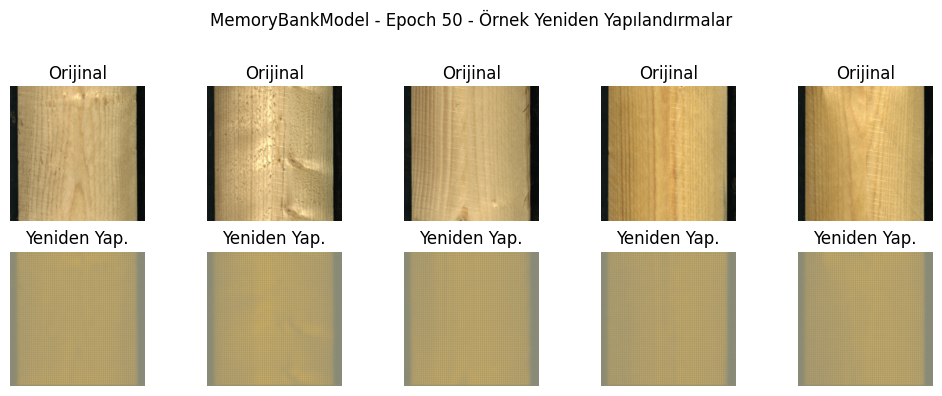

--- MemoryBankModel Modeli Eğitimi Tamamlandı ---


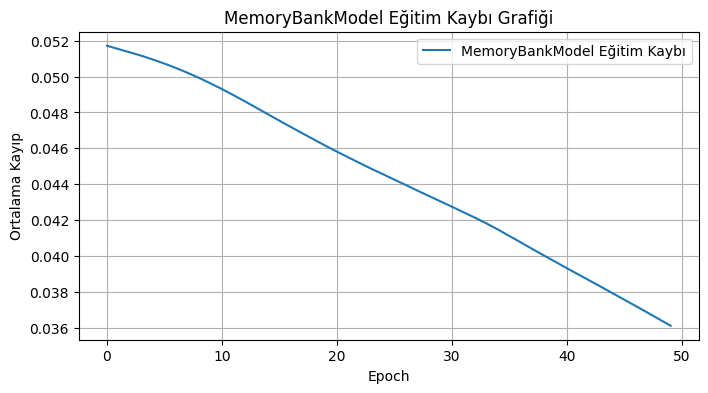

In [69]:
def train_model(model, model_name, train_loader, criterion, optimizer, num_epochs=EPOCHS):
    print(f"--- {model_name} Modeli Eğitimi Başlıyor ---")
    model.train()
    epoch_losses = []
    if len(train_loader.dataset) == 0:
        print(f"Uyarı: {model_name} için eğitim verisi bulunamadı. Eğitim atlanıyor.")
        return epoch_losses

    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_idx, (images, _, _) in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            if (batch_idx + 1) % (max(1, len(train_loader) // 5)) == 0:
                 print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Anlık Kayıp: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] tamamlandı. Ortalama Eğitim Kaybı: {epoch_loss:.6f}")

        if (epoch + 1) % max(1, (num_epochs // 5)) == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                sample_images, _, _ = next(iter(train_loader))
                sample_images = sample_images.to(device)
                reconstructed_samples = model(sample_images)
                fig, axes = plt.subplots(2, min(5, sample_images.size(0)), figsize=(10, 4))
                fig.suptitle(f'{model_name} - Epoch {epoch+1} - Örnek Yeniden Yapılandırmalar')
                for i in range(min(5, sample_images.size(0))):
                    axes[0, i].imshow(sample_images[i].cpu().permute(1, 2, 0).numpy())
                    axes[0, i].set_title("Orijinal")
                    axes[0, i].axis('off')
                    axes[1, i].imshow(reconstructed_samples[i].cpu().permute(1, 2, 0).numpy())
                    axes[1, i].set_title("Yeniden Yap.")
                    axes[1, i].axis('off')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
            model.train()

    print(f"--- {model_name} Modeli Eğitimi Tamamlandı ---")
    return epoch_losses

trained_models_losses = {}
if len(train_loader.dataset) > 0:
    for model_name, model_instance in models_dict.items():
        losses = train_model(model_instance, model_name, train_loader,
                             criterions[model_name], optimizers[model_name], num_epochs=EPOCHS)
        trained_models_losses[model_name] = losses
        if losses:
            plt.figure(figsize=(8, 4))
            plt.plot(losses, label=f'{model_name} Eğitim Kaybı')
            plt.xlabel("Epoch")
            plt.ylabel("Ortalama Kayıp")
            plt.title(f"{model_name} Eğitim Kaybı Grafiği")
            plt.legend()
            plt.grid(True)
            plt.show()
        # torch.save(model_instance.state_dict(), f"{model_name}_wood_anomaly_epochs{EPOCHS}.pth")
else:
    print("Eğitim verisi olmadığından modeller eğitilemedi.")

--- Autoencoder Modeli Değerlendirmesi Başlıyor ---
Optimal Eşik (F1): 0.002824, Max F1: 0.7634, ROC AUC: 0.7905
Ortalama IoU (Kusurlu Örnekler): 0.0000


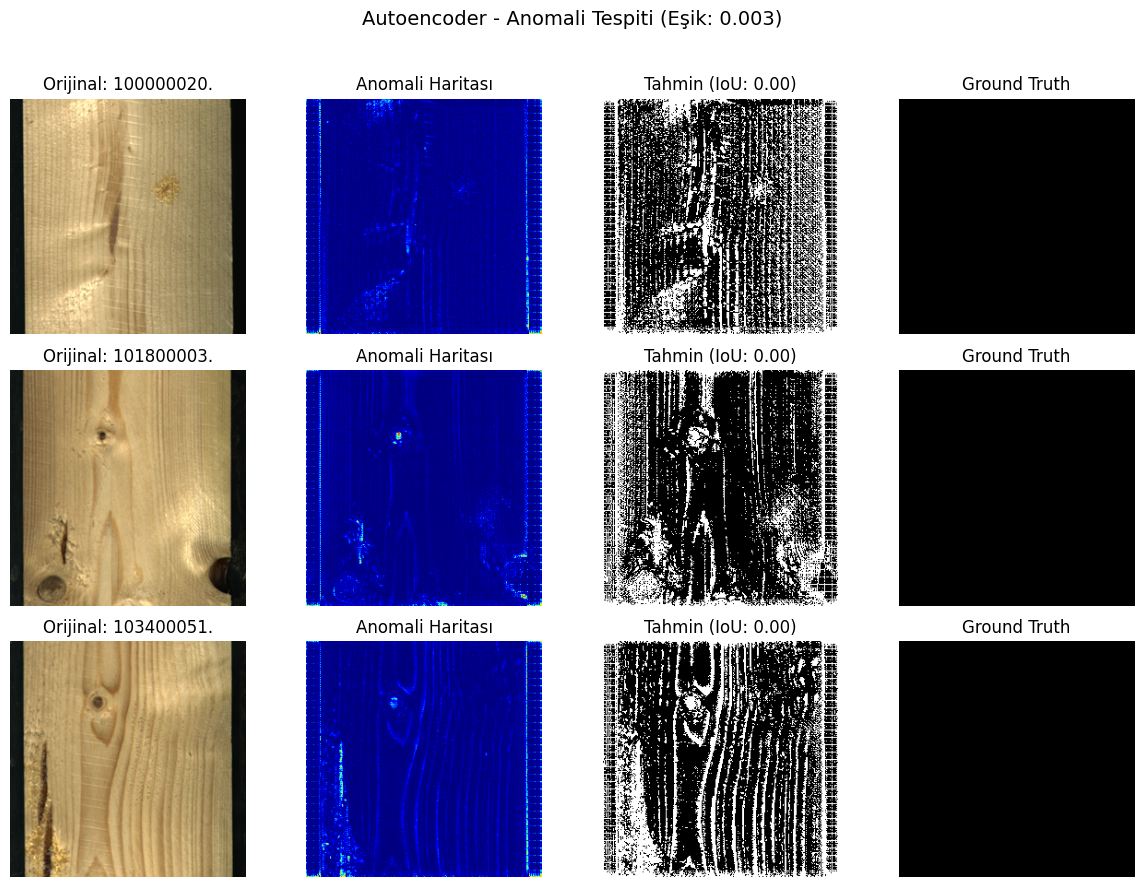

Autoencoder Sonuç: F1=0.7634, ROC_AUC=0.7905, Avg_IoU=0.0000, Eşik=0.002824
--- LCAE Modeli Değerlendirmesi Başlıyor ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
<ipython-input-70-03d92ded997f>:52: RuntimeWarning: invalid value encountered in divide
  f1_scores_pr = np.nan_to_num((2 * precisions * recalls) / (precisions + recalls))


Optimal Eşik (F1): 0.019482, Max F1: 0.7303, ROC AUC: 0.6821
Ortalama IoU (Kusurlu Örnekler): 0.0000


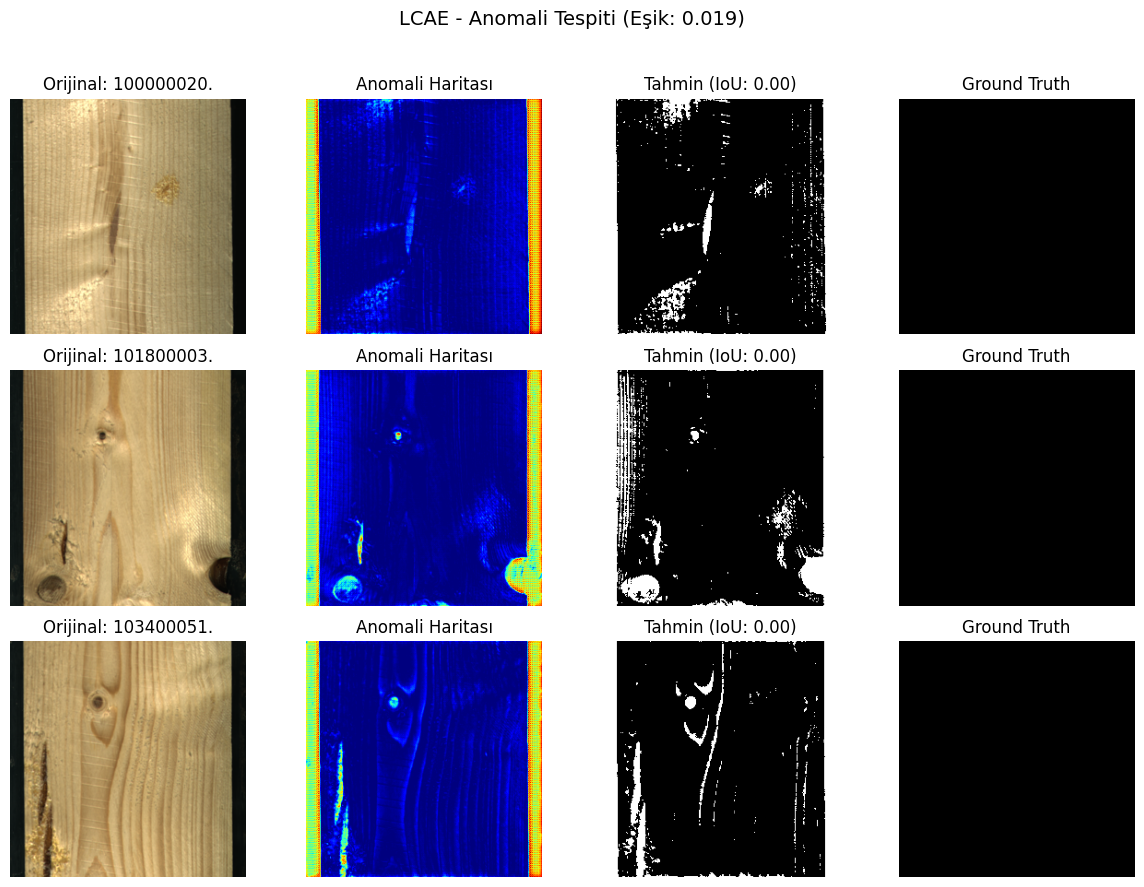

LCAE Sonuç: F1=0.7303, ROC_AUC=0.6821, Avg_IoU=0.0000, Eşik=0.019482
--- MemoryBankModel Modeli Değerlendirmesi Başlıyor ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
<ipython-input-70-03d92ded997f>:52: RuntimeWarning: invalid value encountered in divide
  f1_scores_pr = np.nan_to_num((2 * precisions * recalls) / (precisions + recalls))


Optimal Eşik (F1): 0.032135, Max F1: 0.6885, ROC AUC: 0.6350
Ortalama IoU (Kusurlu Örnekler): 0.0000


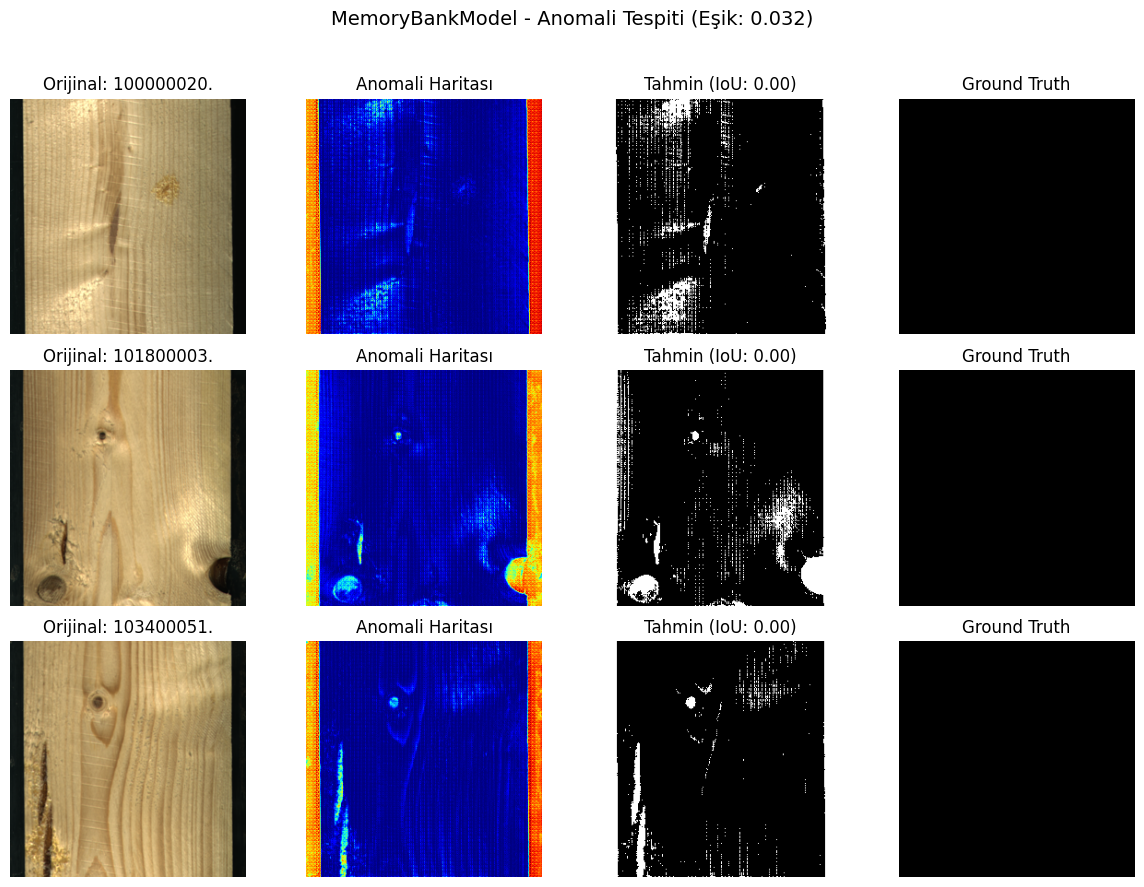

MemoryBankModel Sonuç: F1=0.6885, ROC_AUC=0.6350, Avg_IoU=0.0000, Eşik=0.032135


In [70]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def evaluate_model(model, model_name, test_good_loader, test_defect_loader, criterion, device):
    print(f"--- {model_name} Modeli Değerlendirmesi Başlıyor ---")
    model.eval()
    all_scores, all_labels, all_image_paths = [], [], []
    defect_gt_masks_list, defect_pred_anomaly_maps_list, defect_image_paths = [], [], []

    # Normal test görüntüleri
    if len(test_good_loader.dataset) > 0:
        with torch.no_grad():
            for images, _, paths in test_good_loader:
                images = images.to(device)
                reconstructed = model(images)
                anomaly_maps_batch = F.mse_loss(reconstructed, images, reduction='none')
                scores_batch = torch.mean(anomaly_maps_batch, dim=(1, 2, 3))
                all_scores.extend(scores_batch.cpu().numpy())
                all_labels.extend([0] * images.size(0))
                all_image_paths.extend(paths)
    else:
        print(f"Uyarı: {model_name} için normal test verisi bulunamadı.")

    # Kusurlu test görüntüleri
    if len(test_defect_loader.dataset) > 0:
        with torch.no_grad():
            for images, gt_masks, paths in test_defect_loader:
                if images.nelement() == 0: continue
                images, gt_masks = images.to(device), gt_masks.to(device)
                reconstructed = model(images)
                anomaly_maps_batch = F.mse_loss(reconstructed, images, reduction='none')
                anomaly_maps_single_channel = torch.mean(anomaly_maps_batch, dim=1, keepdim=True)
                scores_batch = torch.mean(anomaly_maps_batch, dim=(1, 2, 3))

                all_scores.extend(scores_batch.cpu().numpy())
                all_labels.extend([1] * images.size(0))
                all_image_paths.extend(paths)
                defect_image_paths.extend(paths)
                defect_gt_masks_list.extend([m.cpu() for m in gt_masks])
                defect_pred_anomaly_maps_list.extend([am.cpu() for am in anomaly_maps_single_channel])
    else:
        print(f"Uyarı: {model_name} için kusurlu test verisi bulunamadı. F1 ve IoU etkilenebilir.")

    if not all_scores: # Eğer hiç skor yoksa (veri yoksa)
        print(f"{model_name}: Değerlendirme için hiç veri bulunamadı.")
        return 0, 0, 0, 0

    all_scores, all_labels = np.array(all_scores), np.array(all_labels)
    max_f1, best_threshold_f1, roc_auc = 0, np.median(all_scores) if all_scores.size > 0 else 0, 0

    if all_labels.size > 0 and np.any(all_labels == 1) and np.any(all_labels == 0): # Hem pozitif hem negatif örnek varsa
        precisions, recalls, thresholds_pr = precision_recall_curve(all_labels, all_scores)
        f1_scores_pr = np.nan_to_num((2 * precisions * recalls) / (precisions + recalls))
        if f1_scores_pr.size > 0:
            max_f1_idx = np.argmax(f1_scores_pr)
            max_f1 = f1_scores_pr[max_f1_idx]
            # thresholds_pr'ın boyutu f1_scores_pr'dan 1 eksik olabilir.
            best_threshold_f1 = thresholds_pr[max_f1_idx] if max_f1_idx < len(thresholds_pr) else (thresholds_pr[-1] if len(thresholds_pr)>0 else best_threshold_f1)

        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        roc_auc = auc(fpr, tpr)
        print(f"Optimal Eşik (F1): {best_threshold_f1:.6f}, Max F1: {max_f1:.4f}, ROC AUC: {roc_auc:.4f}")
        # Grafikler (isteğe bağlı, çok fazla olabilir)
    elif all_labels.size > 0:
        print("F1/ROC AUC hesaplamak için hem normal hem de kusurlu örneklere ihtiyaç var.")
        # Sadece tek bir sınıf varsa, F1 ve ROC AUC anlamlı olmayabilir.
        # Bu durumda eşiği medyan olarak bırakabiliriz.

    # IoU Hesaplaması
    iou_scores = []
    all_pred_masks_for_iou_vis = []
    if defect_pred_anomaly_maps_list:
        for i in range(len(defect_pred_anomaly_maps_list)):
            pred_map_tensor = defect_pred_anomaly_maps_list[i]
            gt_mask_tensor = defect_gt_masks_list[i]
            pred_mask_binary = (pred_map_tensor > best_threshold_f1).float()
            all_pred_masks_for_iou_vis.append(pred_mask_binary.cpu())
            pred_flat = pred_mask_binary.flatten().cpu().numpy().astype(int)
            gt_flat = gt_mask_tensor.flatten().cpu().numpy().astype(int)
            if np.sum(gt_flat) == 0 and np.sum(pred_flat) == 0: iou = 1.0
            elif np.sum(gt_flat) == 0 and np.sum(pred_flat) > 0: iou = 0.0
            else: iou = jaccard_score(gt_flat, pred_flat, average='binary', zero_division=0)
            iou_scores.append(iou)
        avg_iou = np.mean(iou_scores) if iou_scores else 0
        print(f"Ortalama IoU (Kusurlu Örnekler): {avg_iou:.4f}")
    else:
        avg_iou = 0
        print("IoU için kusurlu örnek/tahmin haritası yok.")

    # Görselleştirme (birkaç örnek)
    num_samples_to_show = min(3, len(defect_pred_anomaly_maps_list))
    if num_samples_to_show > 0:
        fig, axes = plt.subplots(num_samples_to_show, 4, figsize=(12, 3 * num_samples_to_show))
        if num_samples_to_show == 1: axes = np.array([axes]) # Tek satırsa 2D yap
        fig.suptitle(f"{model_name} - Anomali Tespiti (Eşik: {best_threshold_f1:.3f})", fontsize=14)
        for i in range(num_samples_to_show):
            img_path = defect_image_paths[i]
            original_image = Image.open(img_path).convert("RGB").resize(IMG_SIZE)
            anomaly_map_vis = defect_pred_anomaly_maps_list[i].squeeze().cpu().numpy()
            pred_mask_vis = all_pred_masks_for_iou_vis[i].squeeze().cpu().numpy()
            gt_mask_vis = defect_gt_masks_list[i].squeeze().cpu().numpy()
            axes[i, 0].imshow(original_image); axes[i, 0].set_title(f"Orijinal: {os.path.basename(img_path)[:10]}"); axes[i, 0].axis('off')
            axes[i, 1].imshow(anomaly_map_vis, cmap='jet'); axes[i, 1].set_title("Anomali Haritası"); axes[i, 1].axis('off')
            axes[i, 2].imshow(pred_mask_vis, cmap='gray'); axes[i, 2].set_title(f"Tahmin (IoU: {iou_scores[i]:.2f})"); axes[i, 2].axis('off')
            axes[i, 3].imshow(gt_mask_vis, cmap='gray'); axes[i, 3].set_title("Ground Truth"); axes[i, 3].axis('off')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    return max_f1, roc_auc, avg_iou, best_threshold_f1

evaluation_results = {}
if not trained_models_losses and not models_dict: # Eğer hiç model eğitilmediyse veya tanımlanmadıysa
    print("Değerlendirilecek eğitilmiş model bulunmamaktadır.")
elif not test_good_loader.dataset and not test_defect_loader.dataset:
    print("Değerlendirme için test verisi bulunamadı.")
else:
    for model_name, model_instance in models_dict.items():
        if model_name in trained_models_losses and not trained_models_losses[model_name]: # Kayıp listesi boşsa (eğitim yapılmadıysa)
             print(f"{model_name} için eğitim yapılmamış, değerlendirme atlanıyor.")
             continue
        if not (hasattr(model_instance, 'forward')):
            print(f"Uyarı: {model_name} geçerli bir model değil. Değerlendirme atlanıyor.")
            continue

        f1, roc_auc, iou, threshold = evaluate_model(model_instance, model_name,
                                              test_good_loader, test_defect_loader,
                                              criterions[model_name], device)
        evaluation_results[model_name] = {"F1_Score": f1, "ROC_AUC": roc_auc, "Avg_IoU": iou, "Best_Threshold": threshold}
        print(f"{model_name} Sonuç: F1={f1:.4f}, ROC_AUC={roc_auc:.4f}, Avg_IoU={iou:.4f}, Eşik={threshold:.6f}")

In [71]:
import pandas as pd

if evaluation_results:
    results_df = pd.DataFrame.from_dict(evaluation_results, orient='index')
    print("\n--- TÜM MODELLERİN DEĞERLENDİRME SONUÇLARI ---")
    print(results_df.to_markdown(numalign="left", stralign="left")) # Daha okunaklı çıktı için markdown formatı
else:
    print("\nDeğerlendirme sonuçları bulunmamaktadır veya bir hata oluştu.")

print("\nÇalışma tamamlandı.")

# import gc
# gc.collect()
# torch.cuda.empty_cache()


--- TÜM MODELLERİN DEĞERLENDİRME SONUÇLARI ---
|                 | F1_Score   | ROC_AUC   | Avg_IoU   | Best_Threshold   |
|:----------------|:-----------|:----------|:----------|:-----------------|
| Autoencoder     | 0.763441   | 0.790543  | 0         | 0.00282407       |
| LCAE            | 0.730337   | 0.682093  | 0         | 0.0194823        |
| MemoryBankModel | 0.688525   | 0.63501   | 0         | 0.0321351        |

Çalışma tamamlandı.


In [ ]:
# Google Drive'daki yolların kontrolü

import os

test_defect_dir = os.path.join(DATASET_PATH, "test", "defect")
ground_truth_dir = os.path.join(DATASET_PATH, "ground_truth", "defect")

# Test/defect klasörünün varlığını kontrol et
if not os.path.exists(test_defect_dir):
    print(f"Hata: Test arıza dizini bulunamadı: {test_defect_dir}")
else:
    test_images_full_paths = sorted([os.path.join(test_defect_dir, f)
                                    for f in os.listdir(test_defect_dir) if f.endswith(".jpg")])

    # Kontrol ve log
    if not test_images_full_paths:
        print(f"Uyarı: {test_defect_dir} dizininde hiç '.jpg' dosyası bulunamadı.")
    else:
        for test_image_path in test_images_full_paths:
            test_image_name = os.path.basename(test_image_path) # Sadece dosya adını al

            base_name = os.path.splitext(test_image_name)[0]
            expected_mask_name = f"{base_name}_mask.jpg"
            expected_mask_path = os.path.join(ground_truth_dir, expected_mask_name)

            print(f"Test dosyası tam yolu: {test_image_path}")
            print(f"Beklenen maske yolu:   {expected_mask_path}")

            if os.path.exists(expected_mask_path):
                print("Durum                : ✅ Maske bulundu.\n")
            else:
                print("Durum                : ❌ Maske BULUNAMADI! Lütfen yolu ve dosya adını kontrol edin.\n")